In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

In [6]:
df_admission = pd.read_csv("./data/HDHI_admission_data.csv")
df_weather = pd.read_csv("./data/HDHI_pollution_data.csv")

In [7]:
# Limpiamos y renombramos las columnas originales del df
df_admission.columns = df_admission.columns.str.strip()

mapping = {
    'SNO': 'serial_number',
    'MRD No.': 'mrd_number',
    'D.O.A': 'admission_date',
    'D.O.D': 'discharge_date',
    'AGE': 'age',
    'GENDER': 'gender',
    'RURAL': 'residence_rural',
    'TYPE OF ADMISSION-EMERGENCY/OPD': 'admission_type',
    'month year': 'admission_month_year',
    'DURATION OF STAY': 'length_of_stay_days',
    'duration of intensive unit stay': 'icu_length_of_stay_days',
    'OUTCOME': 'hospital_outcome',
    'SMOKING': 'smoking_status',
    'ALCOHOL': 'alcohol_use',
    'DM': 'diabetes',
    'HTN': 'hypertension',
    'CAD': 'coronary_artery_disease',
    'PRIOR CMP': 'prior_cva',                     # CMP -> cerebrovascular accident (ajusta si tu significado es otro)
    'CKD': 'chronic_kidney_disease',
    'HB': 'hemoglobin_g_dl',
    'TLC': 'total_leukocyte_count',
    'PLATELETS': 'platelet_count',
    'GLUCOSE': 'glucose_mg_dl',
    'UREA': 'urea_mg_dl',
    'CREATININE': 'creatinine_mg_dl',
    'BNP': 'bnp',
    'RAISED CARDIAC ENZYMES': 'raised_cardiac_enzymes',
    'EF': 'ejection_fraction_percent',
    'SEVERE ANAEMIA': 'severe_anemia',
    'ANAEMIA': 'anemia',
    'STABLE ANGINA': 'stable_angina',
    'ACS': 'acute_coronary_syndrome',
    'STEMI': 'stemi',
    'ATYPICAL CHEST PAIN': 'atypical_chest_pain',
    'HEART FAILURE': 'heart_failure',
    'HFREF': 'hf_ref',                             # HFrEF (reduced EF)
    'HFNEF': 'hf_nef',                             # HFpEF/HFNEF (preserv. EF) — cambia si prefieres hf_pef
    'VALVULAR': 'valvular_disease',
    'CHB': 'complete_heart_block',
    'SSS': 'sick_sinus_syndrome',
    'AKI': 'acute_kidney_injury',
    'CVA INFRACT': 'cva_infarct',
    'CVA BLEED': 'cva_bleed',
    'AF': 'atrial_fibrillation',
    'VT': 'ventricular_tachycardia',
    'PSVT': 'psvt',
    'CONGENITAL': 'congenital_heart_disease',
    'UTI': 'urinary_tract_infection',
    'NEURO CARDIOGENIC SYNCOPE': 'neurocardiogenic_syncope',
    'ORTHOSTATIC': 'orthostatic_hypotension',
    'INFECTIVE ENDOCARDITIS': 'infective_endocarditis',
    'DVT': 'deep_vein_thrombosis',
    'CARDIOGENIC SHOCK': 'cardiogenic_shock',
    'SHOCK': 'shock',
    'PULMONARY EMBOLISM': 'pulmonary_embolism',
    'CHEST INFECTION': 'chest_infection'
}

df_admission.rename(columns=mapping, inplace=True)

In [8]:
# mapa para convertir 'Apr-17' -> 4, 'Mar-19' -> 3, etc.
_MONTH_MAP = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12,
}

def parse_with_disambiguation(
    df,
    date_col,
    month_hint_col=None,
    admission_col=None,
    los_col=None,
    tolerance=2
):
    """
    Convierte una columna de fechas que viene mezclada (DD/MM/YYYY vs MM/DD/YYYY),
    y si se trata de 'discharge_date', valida usando length_of_stay_days.

    Funcionalidades:
    - Hace dos parses: dayfirst y monthfirst.
    - Si solo uno funciona, usa ese.
    - Si los dos funcionan pero dan meses distintos, usa la pista de month_hint_col (si existe).
    - Si la columna corresponde a una fecha de alta (usa admission_col y los_col),
      recalcula discharge_date = admission_date + length_of_stay_days
      cuando la diferencia entre fechas difiere más que el parámetro `tolerance`.
    """

    raw = df[date_col].astype(str)

    # 1️⃣ Dos intentos de parseo
    d_dayfirst = pd.to_datetime(raw, errors='coerce', dayfirst=True)
    d_monthfirst = pd.to_datetime(raw, errors='coerce', dayfirst=False)

    # 2️⃣ Base: usar el que no sea NaT
    result = d_dayfirst.fillna(d_monthfirst)

    # 3️⃣ Filas ambiguas: ambos válidos pero con meses distintos
    amb_mask = (
        d_dayfirst.notna()
        & d_monthfirst.notna()
        & (d_dayfirst.dt.month != d_monthfirst.dt.month)
    )

    if month_hint_col is not None and month_hint_col in df.columns:
        # Extraer el mes esperado del hint (ej. 'Apr-17' -> 4)
        hint_str = df.loc[amb_mask, month_hint_col].astype(str).str[:3]
        hint_month = hint_str.map(_MONTH_MAP)

        # Elegir según coincidencia con el mes esperado
        use_dayfirst = d_dayfirst.loc[amb_mask].dt.month.eq(hint_month)
        chosen = d_dayfirst.loc[amb_mask].where(use_dayfirst, d_monthfirst.loc[amb_mask])
        result.loc[amb_mask] = chosen
    else:
        # Sin pista → priorizamos month-first
        result.loc[amb_mask] = d_monthfirst.loc[amb_mask]

    # 4️⃣ Si se trata de discharge_date, validar con length_of_stay_days
    if admission_col and los_col and all(col in df.columns for col in [admission_col, los_col]):
        adm = pd.to_datetime(df[admission_col], errors="coerce")
        los = df[los_col]

        # Calcular diferencia actual
        stay_diff = (result - adm).dt.days

        # Detectar inconsistencias (mayor al margen permitido)
        bad_mask = stay_diff.sub(los).abs() > tolerance

        if bad_mask.any():
            print(f"{bad_mask.sum()} fechas inconsistentes detectadas en '{date_col}', recalculando...")

            # Recalcular discharge_date = admission_date + length_of_stay_days
            result.loc[bad_mask] = adm.loc[bad_mask] + pd.to_timedelta(los.loc[bad_mask], unit="D")

        # Verificación final
        new_diff = (result - adm).dt.days
        inconsistentes = (new_diff.sub(los).abs() > tolerance).sum()
        if inconsistentes:
            print(f"{inconsistentes} filas aún no coinciden tras la corrección en '{date_col}'.")

    return result


In [9]:
# Parsear admission_date usando la pista de mes
df_admission['admission_date'] = parse_with_disambiguation(
    df_admission,
    date_col='admission_date',
    month_hint_col='admission_month_year'
)

# Parsear discharge_date verificando coherencia con length_of_stay_days
df_admission['discharge_date'] = parse_with_disambiguation(
    df_admission,
    date_col='discharge_date',
    month_hint_col=None,  # no siempre disponible
    admission_col='admission_date',
    los_col='length_of_stay_days',
    tolerance=2
)


df_weather['DATE'] = pd.to_datetime(
  df_weather['DATE'], 
  dayfirst=False, 
  errors='coerce'
)

df_admission.head(10)

3552 fechas inconsistentes detectadas en 'discharge_date', recalculando...


,serial_number,mrd_number,admission_date,discharge_date,age,gender,residence_rural,admission_type,admission_month_year,length_of_stay_days,...,congenital_heart_disease,urinary_tract_infection,neurocardiogenic_syncope,orthostatic_hypotension,infective_endocarditis,deep_vein_thrombosis,cardiogenic_shock,shock,pulmonary_embolism,chest_infection
0,1,234735,2017-04-01,2017-04-03,81,M,R,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
1,2,234696,2017-04-01,2017-04-05,65,M,R,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,2017-04-01,2017-04-03,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
3,4,234635,2017-04-01,2017-04-08,67,F,U,E,Apr-17,8,...,0,0,0,0,0,0,0,0,0,0
4,5,234486,2017-04-01,2017-04-23,60,F,U,E,Apr-17,23,...,0,0,0,0,0,0,0,0,0,0
5,6,234675,2017-04-01,2017-04-10,44,M,U,E,Apr-17,10,...,0,0,0,0,0,0,0,0,0,0
6,7,234563,2017-04-01,2017-04-06,56,F,U,E,Apr-17,6,...,0,0,0,0,0,0,0,0,0,0
7,8,208455,2017-04-01,2017-04-13,47,M,U,E,Apr-17,13,...,0,0,0,0,0,0,0,0,0,0
8,9,67070,2017-04-01,2017-04-03,65,F,U,E,Apr-17,3,...,0,0,0,0,0,0,0,1,0,0
9,10,153218,2017-04-01,2017-04-03,59,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Creamos una máscara para filas con fecha de admisión faltante pero con datos válidos
mask = (
  df_admission['admission_date'].isna() & 
  df_admission['discharge_date'].notna() & 
  df_admission['length_of_stay_days'].notna()
)

# Accedemos a todas las filas donde la mascara sea True y realizamos la imputacion
df_admission.loc[mask, 'admission_date'] = (
  df_admission.loc[mask, 'discharge_date'] - 
  pd.to_timedelta(df_admission.loc[mask, 'length_of_stay_days'], unit='D')
)


In [11]:
# Creamos una máscara para filas con fecha de alta faltante pero con datos válidos
mask = (df_admission['admission_date'].notna() &
        df_admission['length_of_stay_days'].notna() & 
        df_admission['discharge_date'].isna()        
)

df_admission.loc[mask, 'discharge_date'] = (
        df_admission.loc[mask, 'admission_date'] + 
        pd.to_timedelta(df_admission.loc[mask, 'length_of_stay_days'], unit='D')
)

In [12]:
# Eliminamos las filas que tanto 'admission_date' como 'discharge_date' son nulas
df_admission = df_admission.dropna(subset = ['admission_date', 'discharge_date'], how='all')

df_admission.isna().sum().sort_values(ascending=False)

bnp                          8441
ejection_fraction_percent    1505
glucose_mg_dl                 863
total_leukocyte_count         286
platelet_count                285
hemoglobin_g_dl               252
creatinine_mg_dl              247
urea_mg_dl                    241
admission_type                  0
residence_rural                 0
gender                          0
age                             0
discharge_date                  0
admission_month_year            0
icu_length_of_stay_days         0
length_of_stay_days             0
hypertension                    0
diabetes                        0
alcohol_use                     0
smoking_status                  0
hospital_outcome                0
serial_number                   0
admission_date                  0
mrd_number                      0
prior_cva                       0
coronary_artery_disease         0
chronic_kidney_disease          0
raised_cardiac_enzymes          0
severe_anemia                   0
anemia        

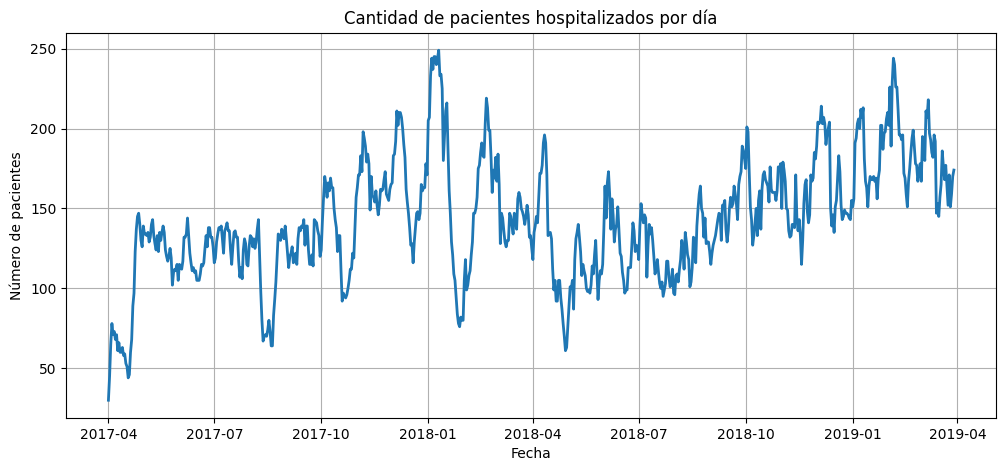

In [13]:

# Expandir el rango de fechas por paciente
df_expanded = (
    df_admission
    .apply(lambda row: pd.date_range(row['admission_date'], row['discharge_date'], freq='D'), axis=1)
    .explode()
    .to_frame(name='date')
)

# Agregar el ID del paciente
df_expanded['serial_number'] = df_admission.loc[df_expanded.index, 'serial_number'].values

# Agrupamos por fecha y contamos
daily_counts = (
    df_expanded
    .groupby('date')
    .size()
    .reset_index(name='num_patients')
)

# Excluimos los ultimos 25 valores ya que sesgan el modelo
daily_counts = daily_counts.iloc[:-25]


# Graficamos la serie temporal
plt.figure(figsize=(12,5))
plt.plot(daily_counts['date'], daily_counts['num_patients'], linewidth=2)
plt.title('Cantidad de pacientes hospitalizados por día')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes')
plt.grid(True)
plt.show()


In [14]:
# ===========================
# 4. Procesar datos climáticos
# ===========================
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], errors='coerce', dayfirst=True)

# Seleccionamos variables numéricas relevantes
weather_vars = [
    'PM2.5 AVG', 'PM10 AVG', 'NO2 AVG', 'OZONE AVG',
    'MAX TEMP', 'MIN TEMP', 'HUMIDITY'
]
df_weather = df_weather[['DATE'] + weather_vars].dropna()

# ===========================
# 5. Unir datasets
# ===========================
df = pd.merge(daily_counts, df_weather, left_on='date', right_on='DATE', how='inner').drop(columns=['DATE'])


In [15]:
df

,date,num_patients,PM2.5 AVG,PM10 AVG,NO2 AVG,OZONE AVG,MAX TEMP,MIN TEMP,HUMIDITY
0,2017-04-01,30,38,35,20,44,40,24,16.0
1,2017-04-02,45,53,59,18,40,40,21,14.0
2,2017-04-03,65,62,70,10,47,39,22,14.0
3,2017-04-04,78,70,63,12,50,39,23,23.0
4,2017-04-05,71,88,85,6,40,36,20,51.0
...,...,...,...,...,...,...,...,...,...
719,2019-03-25,171,68,69,1,19,27,15,51.0
720,2019-03-26,151,98,90,1,34,29,15,51.0
721,2019-03-27,159,93,86,2,34,30,16,35.0
722,2019-03-28,170,103,94,2,54,31,17,32.0


MAE: 14.71
R²: 0.462


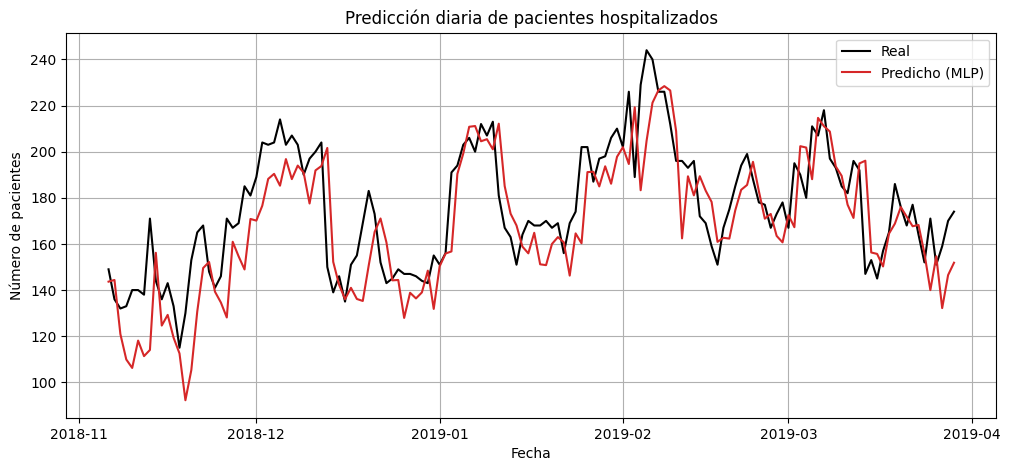

In [ ]:
# ===========================
# 6. Crear variables de rezago (lags)
# ===========================
for lag in range(1, 8):  # memoria de 7 días
    df[f'lag_{lag}'] = df['num_patients'].shift(lag)

df = df.dropna().reset_index(drop=True)

# ===========================
# 7. Variables predictoras y target
# ===========================
feature_cols = [col for col in df.columns if col not in ['date', 'num_patients']]
X = df[feature_cols]
y = df['num_patients']

# ===========================
# 8. División temporal train/test
# ===========================
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# ===========================
# 9. Pipeline Random Forest
# ===========================
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# ===========================
# 10. Entrenamiento
# ===========================
rf_pipeline.fit(X_train, y_train)

# ===========================
# 11. Evaluación
# ===========================
y_pred = rf_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

# ===========================
# 12. Visualización
# ===========================
plt.figure(figsize=(12,5))
plt.plot(df['date'].iloc[split_idx:], y_test.values, label='Real', color='black')
plt.plot(df['date'].iloc[split_idx:], y_pred, label='Predicho (Random Forest)', color='tab:green')
plt.title('Predicción diaria de pacientes hospitalizados')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes')
plt.legend()
plt.grid(True)
plt.show()
